name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          2875
snow                 974
snowdepth            958
windgust            6048
windspeed              0
winddir                0
sealevelpressure     325
cloudcover             0
visibility             0
solarradiation      3653
solarenergy         3653
uvindex             3653
severerisk          8045
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64
name                0.000000
tempmax             0.000000
tempmin             0.000000
temp                0.000000
feelslikemax        0.000000
feelslikemin        0.000000
feelslike    

C:\Users\12783\AppData\Local\Temp\ipykernel_6336\659713015.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',


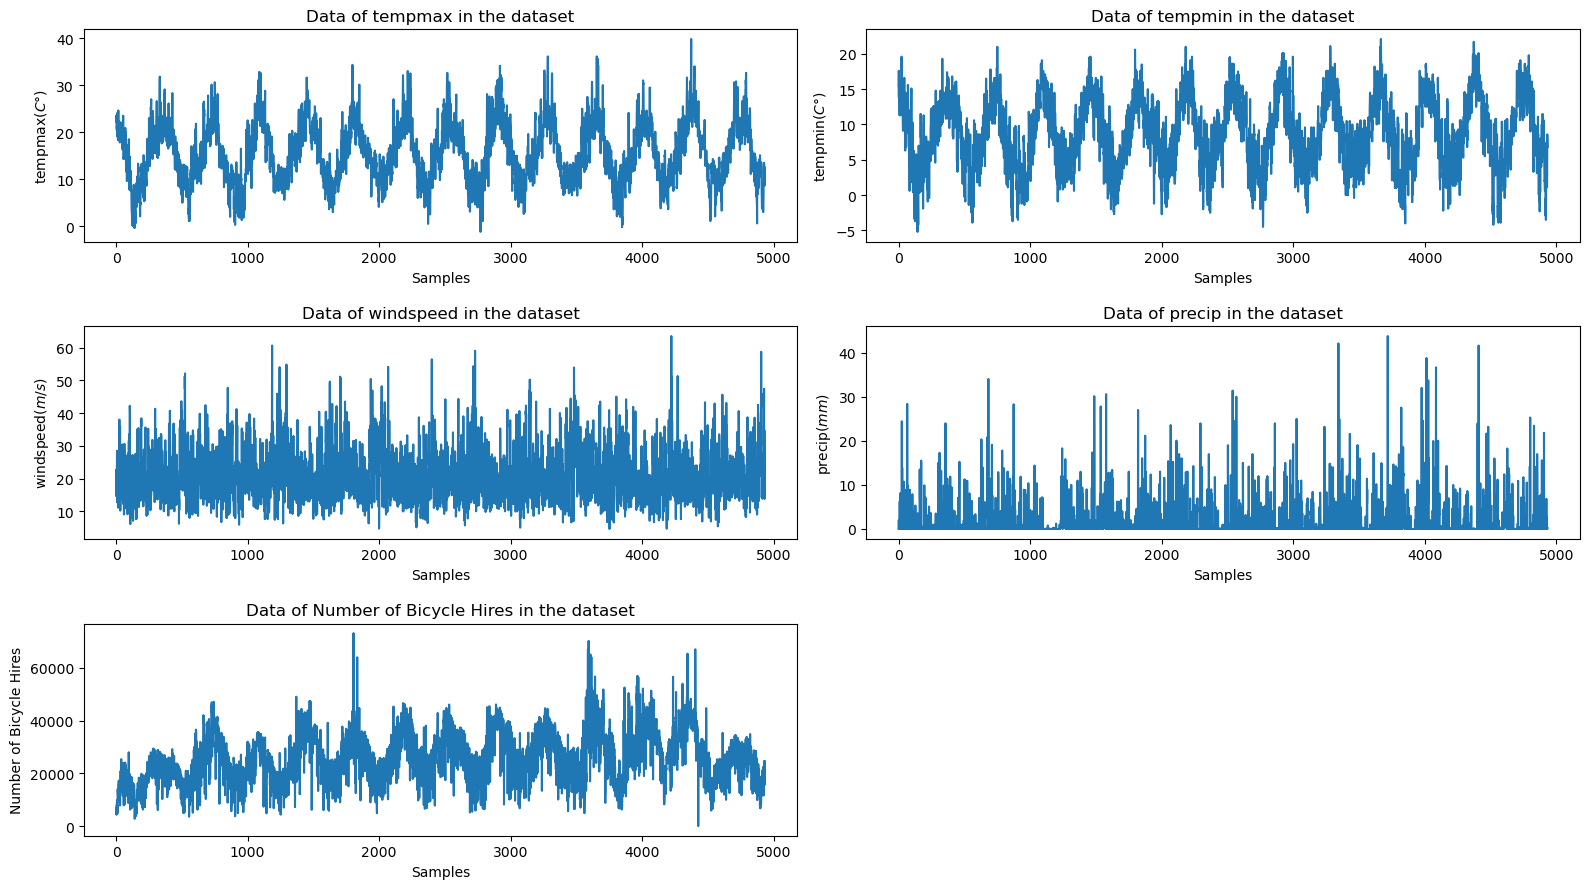

In [7]:
import pandas as pd
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ##============= Data loading and processing =============##
# loading dataset into the program
dataset1 = pd.read_csv('../DataSets/London 2000-01-01 to 2024-01-31.csv', index_col="datetime")
dataset2 = pd.read_csv(r'../DataSets/tfl-daily-cycle-hires.csv', index_col="Day", parse_dates=["Day"])

# define the features we want to predict
target_features = ['tempmax', 'tempmin', 'windspeed', 'precip', 'Number of Bicycle Hires']
features_unit = ['($C°$)', '($C°$)', '($m / s$)', '($mm$)', '']

# filter dataset1 from 2010.07.30 to 2024.01.31 to fit with dataset2
start_date = pd.to_datetime('2010-07-30')
dataset1.index = pd.to_datetime(dataset1.index)
dataset1_filtered = dataset1[(dataset1.index >= start_date)]

# Checking number of missing data in every column
print(dataset1.isnull().sum())

# checking percentage of missing data in a column
perc_missing_values = dataset1.isnull().sum()/dataset1.shape[0]
print(perc_missing_values)

# delete useless columns and columns with too many NaN values
dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',
                                'preciptype', 'precipprob', 'solarradiation',
                                'solarenergy', 'uvindex', 'sunrise',
                                'sunset', 'conditions', 'description',
                                'icon', 'stations', 'sunset'],
                       inplace=True)

# combining the two datasets
merged_data = pd.merge(dataset1_filtered, dataset2, left_index=True, right_index=True, how='outer')

# change the values of bike hires to float
merged_data['Number of Bicycle Hires'] = merged_data['Number of Bicycle Hires'].apply(lambda x: float(x.replace(',', '')))

# Filling in the missing data in columns by the previous day values
merged_data = merged_data.ffill()

# Checking how many entries for each year to identify if there is any day weather record is missing
print(merged_data.index.year.value_counts().sort_index())

# Analyze the read weather data and draw temperature data
plt.figure(figsize=(16, 9))
for i, feature in enumerate(target_features):
    value = merged_data.loc[:, feature]

    plt.subplot(3, 2, i + 1)
    plt.plot(range(len(value)), value)  # paint all data
    plt.xlabel('Samples')
    plt.ylabel(r'' + feature + features_unit[i])

    plt.title('Data of ' + feature + ' in the dataset')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [8]:
# ##======== Prepare the datasets required for the model ========##
# Normalise data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data)
scaled_data = pd.DataFrame(scaled_data, columns=merged_data.columns)
deltas = merged_data.max() - merged_data.min()

In [9]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_data)
principal_data = pd.DataFrame(principalComponents)

In [10]:
# Specify the ratio of training set, validation set, and test set
train_ratio = 0.7
val_ratio = 0.15
# test_ratio = 0.15

# Calculate the size of the training, validation, and testing sets
train_size = int(len(scaled_data) * train_ratio)
val_size = int(len(scaled_data) * val_ratio)

lookback = 30   # use the data of last 30 days to predict that of next day
N = 1           # forecast the weather on the Nth day
date = N-1
feature = 'Number of Bicycle Hires'

referencing_mae = pd.DataFrame(index=range(N), columns=target_features)
test_mae = pd.DataFrame(index=range(N), columns=target_features)
train_history = pd.DataFrame(index=range(N), columns=target_features)

# Calculate correlation matrix
correlation_matrix = scaled_data.corr()

In [13]:
# Extract correlations with the target variable
correlation_with_target = correlation_matrix[feature].abs().sort_values(ascending=False)
# Print the correlation results
print("Correlation with", feature)
print(correlation_with_target)

# Only retain features have high correlation with the target feature
features_used = list(correlation_with_target[correlation_with_target > 0.3].index)
filtered_data = scaled_data.loc[:, features_used]

#for date in range(N):
print(f'##======The model of {feature} on Day{date+1} is now being trained...======##')

# generate x_train and y_train
x_train = []
y_train = []
for i in range(lookback + date, train_size + 1):
    x_train.append(principal_data[i - lookback - date:i - date])
    y_train.append(filtered_data.loc[i, feature])
x_train, y_train = np.array(x_train), np.array(y_train)

# generate x_val and y_val
x_val = []
y_val = []
for i in range(train_size + lookback + date, train_size + val_size + 1):
    x_val.append(principal_data[i - lookback - date:i - date])
    y_val.append(filtered_data.loc[i, feature])
x_val, y_val = np.array(x_val), np.array(y_val)

# generate x_test and y_test
x_test = []
y_test = []
x_test_orig = []
for i in range(train_size + val_size + lookback + date, len(scaled_data)):
    x_test.append(principal_data[i - lookback - date:i - date])
    x_test_orig.append(filtered_data[i - lookback - date:i - date])
    y_test.append(filtered_data.loc[i, feature])
x_test, x_test_orig, y_test = np.array(x_test), np.array(x_test_orig), np.array(y_test)

# A common sense based, non machine learning method  is
# used to calculate the MAE (Mean Absolute Error) of a
# common sense based method that always predicts that
# the next day's data is equal to the previous day's data.
y_pred = x_test_orig[:, -1, 0]
error = y_pred - y_test
mae = np.mean(np.abs(error), axis=0)
referencing_mae.at[date, feature] = np.abs(mae*deltas[feature])


Correlation with Number of Bicycle Hires
Number of Bicycle Hires    1.000000
tempmax                    0.665967
feelslikemax               0.656190
feelslike                  0.628271
temp                       0.627140
feelslikemin               0.561291
tempmin                    0.532482
humidity                   0.520494
dew                        0.432006
cloudcover                 0.346182
precipcover                0.307268
visibility                 0.263627
precip                     0.252936
sealevelpressure           0.236857
windspeed                  0.220491
snowdepth                  0.133447
snow                       0.087328
winddir                    0.004627
moonphase                  0.003145
Name: Number of Bicycle Hires, dtype: float64
##======The model of Number of Bicycle Hires on Day1 is now being trained...======##


In [18]:
principal_data.shape

(4934, 2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 32)          3456      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,873
Trainable params: 5,873
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
27/27 [==============================] - 11s 161ms/step - loss: 0.1452 - val_loss: 0.1067
Epoch 2/25
27/27 [==============================] - 3s 127ms/step - loss: 0.0822 - val_loss: 0.0918
Epoch 3/25
27/27 [==============================] - 3s 129ms/step - loss: 0.0820 - val_loss: 0.1010
Epoch 4/25
27/2

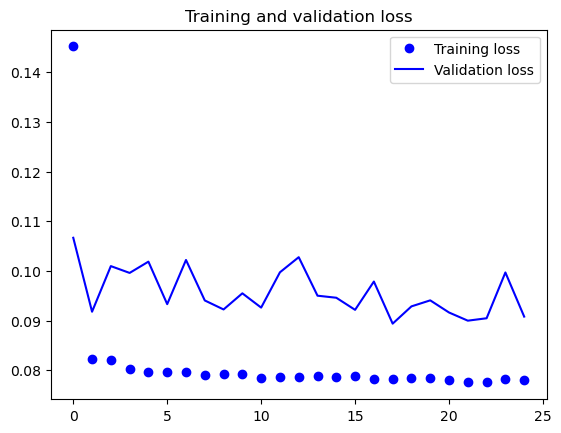

<Figure size 640x480 with 0 Axes>

Reference Error:
  tempmax tempmin windspeed precip Number of Bicycle Hires
0     NaN     NaN       NaN    NaN             4219.939522
Test Error:
    tempmax tempmin windspeed precip Number of Bicycle Hires
0  3.778808     NaN       NaN    NaN             6016.312576


In [20]:
# ##=========== build and train the model ===========##
# Train and evaluate a stacked GRU model using dropout regularization
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, principal_data.shape[-1])))
model.add(layers.GRU(16,
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

# compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mae')
history = model.fit(x_train, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# ##================ test the model ================##
# test_mae.at[date, feature] = model.evaluate(x_test, y_test, verbose=0)*std[feature]
# score = model.evaluate(x_test, y_test, verbose=0)
# test_mae.at[date, feature] = scaler.inverse_transform(score)
score = model.evaluate(x_test, y_test, verbose=0)
#test_mae.at[date,feature] = scalers[feature].inverse_transform([[score]])[0][0]
test_mae.at[date, feature] = score*deltas[feature]

plt.tight_layout()
plt.show()

print('Reference Error:')
print(referencing_mae)
print('Test Error:')
print(test_mae)



